### Integrantes

- Breno da Silva Nogueira
- Caio Vinícius de Melo
- Juliana Almeida Santos

## Parte 1: Mexendo no dataset

In [35]:
import numpy as np
import matplotlib as mtl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Importando o dataset de classificação "mnist"
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Separando os atributos entre preditores e alvo
X, y = mnist["data"], mnist["target"]
X

/home/breno/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
X.shape # 70000 imagens com 784 pixels (28x28)

(70000, 784)

In [37]:
y.shape # 70000 classificações das imagens

(70000,)

Esse número é o '5'


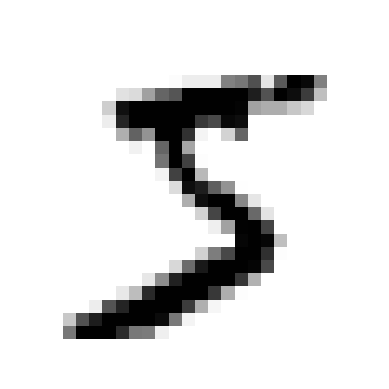

In [38]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mtl.cm.binary)
plt.axis("off")

print("Esse número é o '", y[0], "'", sep="")
plt.show()

In [39]:
from sklearn.model_selection import train_test_split

# Normalizando o valor dos pixels das imagens
X = X / 255
y = y.astype("int")

# Fazendo a divisão de teste e treino com 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3, shuffle=True)
X_train.shape, X.shape

((49000, 784), (70000, 784))

In [40]:
y

array([5, 0, 4, ..., 4, 5, 6])

## Parte 2 - Construção do Modelo de Rede Neural

In [41]:
class MultiLayerPerceptron:
    def __init__(self, random_state=42, learning_rate=.1, epochs=100, activation="relu"):
        np.random.seed(random_state)
        # Épocas que o modelo será treinado e qual função de ativação será
        self.epochs = epochs
        # Velocidade de treinamento
        self.lrnrate = learning_rate
        # Pesos da rede
        self.W1 = np.random.rand(10, 784) - 0.5
        self.W2 = np.random.rand(10, 10) - 0.5
        # Biases da rede neural
        self.b1 = np.random.rand(10, 1) - 0.5
        self.b2 = np.random.rand(10, 1) - 0.5
        # Dados 
        self.X = None
        self.y = None

        # Funções de ativação e derivadas
        if activation == "relu":
            self.activate = self.ReLU
            self.deriv = self.ReLU_deriv
        else:
            self.activate = self.Sigmoid
            self.deriv = self.Sigmoid_deriv


    # Função para treinar o modelo
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.__fitter()

    # Função de Ativação de Tangente Hiperbolica 
    def Sigmoid(self, Z):
        sig = lambda x: 1/(1 + np.exp(-x))
        return sig(Z)
    
    # Derivada da Sigmoide
    def Sigmoid_deriv(self, Z):
        return self.Sigmoid(Z) * (1 - self.Sigmoid(Z))
    
     # Função de Ativação ReLU
    def ReLU(self, Z):
        return np.maximum(Z, 0)
    
    # Derivada da ReLU 
    def ReLU_deriv(self, Z):
        return Z > 0
   
    # Função de ativação de output softmax, dando as probabilidades de classificação
    def softmax(self, Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    
    # Método de forward propagation para o cálculo dos pesos com um hidden layer e do output layer
    def forward_prop(self, X):
        # Calculo do hidden layer
        Z1 = self.W1.dot(X.T) + self.b1
        A1 = self.activate(Z1)
        
        # Cálculo do Output Layer
        Z2 = self.W2.dot(A1) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    # Codificação One-Hot para as predições da rede neural serem atualizadas
    def one_hot(self, Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y

    # Faz o backward propagation do modelo
    def backward_prop(self, Z1, A1, Z2, A2, X, Y):
        m = Y.size
        # Transformação de One-Hot 
        one_hot_Y = self.one_hot(Y)
        
        # Backward propagation do output layer
        dZ2 = A2 - one_hot_Y
        dW2 = 1 / m * dZ2.dot(A1.T)
        db2 = 1 / m * np.sum(dZ2)

        # Backward propagation do hidden layer
        dZ1 = self.W2.T.dot(dZ2) * self.deriv(Z1)
        dW1 = 1 / m * dZ1.dot(X)
        db1 = 1 / m * np.sum(dZ1)
        return dW1, db1, dW2, db2

    # Atualizar os pesos e biases com as derivadas do ReLU e o learning rate  
    def update_params(self, dW1, db1, dW2, db2, alpha):
        self.W1 = self.W1 - alpha * dW1
        self.b1 = self.b1 - alpha * db1    
        self.W2 = self.W2 - alpha * dW2  
        self.b2 = self.b2 - alpha * db2    

    # Pega as maiores possibilidades calculadas e retorna
    def get_predictions(self, A2):
        return np.argmax(A2, 0)

    # Retona o quão preciso o modelo está sendo
    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    # Faz um pretty print da época de treinamento do modelo
    def pprint_epoch(self, i, A2):
        predictions = self.get_predictions(A2)
        print(f"W1: {self.W1} - W2: {self.W2}")
        if i < 0:
            print(f"Acurácia final => Pesos: W1 {self.W1}", f"{self.get_accuracy(predictions, self.y) * 100:.2f}%")
        else:
            print("Época: ", i , " => ", f"{self.get_accuracy(predictions, self.y) * 100:.2f}%")

    # Faz o treinamento do modelo
    def __fitter(self):
        # Itera pelas épocas
        for i in range(self.epochs):
            # Faz o forward propagation com um layer de input, um hidden layer e um output layer
            Z1, A1, Z2, A2 = self.forward_prop(self.X)
            # Faz o backward propagation
            dW1, db1, dW2, db2 = self.backward_prop(Z1, A1, Z2, A2, self.X, self.y)
            # Atualiza os pesos e biases do modelo
            self.update_params(dW1, db1, dW2, db2, self.lrnrate)

            # Faz o log de época a cada 10 iterações
            if i % 10 == 0:
                self.pprint_epoch(i, A2)
        
        _, _, _, A2 = self.forward_prop(self.X)
        self.pprint_epoch(-1, A2)

    # Retorna as predições do modelo
    def predict(self, X):
        # Usa os pesos e biases para fazer as predições e retorna uma matriz 
        _, _, _, A2 = self.forward_prop(X)
        predictions = self.get_predictions(A2)
        return predictions

## Parte 3 - Testar o Modelo

In [42]:
# Primeiro fazer o modelo com a ativação ReLU
mlp_relu = MultiLayerPerceptron(activation="relu", epochs=5000)
mlp_relu.fit(X_train, y_train)
predictions_relu = mlp_relu.predict(X_test)
predictions_relu


Época:  0  =>  11.93%
Época:  10  =>  19.89%
Época:  20  =>  27.49%
Época:  30  =>  34.05%
Época:  40  =>  40.50%
Época:  50  =>  46.77%
Época:  60  =>  52.58%
Época:  70  =>  57.25%
Época:  80  =>  61.14%
Época:  90  =>  63.98%
Época:  100  =>  66.22%
Época:  110  =>  67.93%
Época:  120  =>  69.38%
Época:  130  =>  70.63%
Época:  140  =>  71.77%
Época:  150  =>  72.80%
Época:  160  =>  73.83%
Época:  170  =>  74.70%
Época:  180  =>  75.47%
Época:  190  =>  76.22%
Época:  200  =>  76.92%
Época:  210  =>  77.54%
Época:  220  =>  78.07%
Época:  230  =>  78.53%
Época:  240  =>  79.00%
Época:  250  =>  79.48%
Época:  260  =>  79.91%
Época:  270  =>  80.36%
Época:  280  =>  80.78%
Época:  290  =>  81.10%
Época:  300  =>  81.35%
Época:  310  =>  81.66%
Época:  320  =>  81.92%
Época:  330  =>  82.20%
Época:  340  =>  82.46%
Época:  350  =>  82.68%
Época:  360  =>  82.86%
Época:  370  =>  83.08%
Época:  380  =>  83.27%
Época:  390  =>  83.47%
Época:  400  =>  83.62%
Época:  410  =>  83.78%
Épo

array([8, 4, 5, ..., 2, 4, 5])

In [43]:
mlp_sig = MultiLayerPerceptron(activation="sigmoid", epochs=5000)
mlp_sig.fit(X_train, y_train)

predictions_sig = mlp_sig.predict(X_test)

Época:  0  =>  14.45%
Época:  10  =>  15.64%
Época:  20  =>  17.82%
Época:  30  =>  20.91%
Época:  40  =>  24.19%
Época:  50  =>  27.07%
Época:  60  =>  29.78%
Época:  70  =>  31.81%
Época:  80  =>  33.86%
Época:  90  =>  35.89%
Época:  100  =>  37.79%
Época:  110  =>  39.74%
Época:  120  =>  41.67%
Época:  130  =>  43.48%
Época:  140  =>  45.26%
Época:  150  =>  46.92%
Época:  160  =>  48.56%
Época:  170  =>  50.19%
Época:  180  =>  51.68%
Época:  190  =>  53.16%
Época:  200  =>  54.69%
Época:  210  =>  56.11%
Época:  220  =>  57.39%
Época:  230  =>  58.51%
Época:  240  =>  59.68%
Época:  250  =>  60.69%
Época:  260  =>  61.61%
Época:  270  =>  62.48%
Época:  280  =>  63.38%
Época:  290  =>  64.16%
Época:  300  =>  64.97%
Época:  310  =>  65.67%
Época:  320  =>  66.41%
Época:  330  =>  67.08%
Época:  340  =>  67.72%
Época:  350  =>  68.26%
Época:  360  =>  68.82%
Época:  370  =>  69.40%
Época:  380  =>  69.90%
Época:  390  =>  70.30%
Época:  400  =>  70.81%
Época:  410  =>  71.21%
Épo

In [45]:
# Vamos ver se ele consegue prever um dígito aleatório
some_digit = X_train[0]
single_relu = mlp_relu.predict(np.array([some_digit]))
single_sig = mlp_sig.predict(np.array([some_digit]))

Esse número é o '0'
O ReLU diz que é:  0
O Sigmóide diz que é:  0


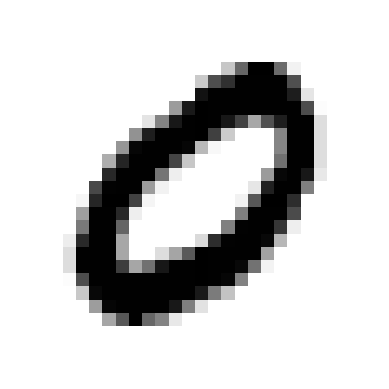

In [48]:

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mtl.cm.binary)
plt.axis("off")

print("Esse número é o '", y_train[0], "'", sep="")
print("O ReLU diz que é: ", single_relu[0])
print("O Sigmóide diz que é: ", single_sig[0] )

plt.show()


In [55]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("ReLU:")
print(f"\tAcurácia: {accuracy_score(y_test, predictions_relu)}")
print(f"\tRevocação: {recall_score(y_test, predictions_relu, average='micro')}")
print(f"\tPrecisão: {precision_score(y_test, predictions_relu, average='micro')}")
print(f"\tF1-Score: {f1_score(y_test, predictions_relu, average='micro')}")
print("\n============================= || =============================\n")
print("Sigmóide:")
print(f"\tAcurácia: {accuracy_score(y_test, predictions_sig)}")
print(f"\tRevocação: {recall_score(y_test, predictions_sig, average='micro')}")
print(f"\tPrecisão: {precision_score(y_test, predictions_sig, average='micro')}")
print(f"\tF1-Score: {f1_score(y_test, predictions_sig, average='micro')}")

ReLU:
	Acurácia: 0.9191428571428572
	Revocação: 0.9191428571428572
	Precisão: 0.9191428571428572
	F1-Score: 0.9191428571428572

============================= || =============================

Sigmóide:
	Acurácia: 0.8999047619047619
	Revocação: 0.8999047619047619
	Precisão: 0.8999047619047619
	F1-Score: 0.8999047619047619
